## XỬ LÝ INPUT

## --------------------------------------------------------------------------------------------------------------------------------

In [1]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

(300, 2465, 3)

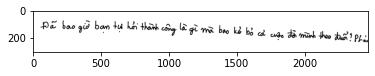

In [2]:
img = cv2.imread('../handwirtting_text2/datasets/dataset_2/images/20140603_0003_BCCTC_1.png')
plt.imshow(img)
w,h,c = img.shape
w,h,c

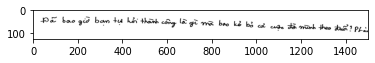

In [25]:
img_resize = cv2.resize(img,(1500,128))
plt.imshow(img_resize)

In [26]:

fh = open('../handwirtting_text2/datasets/dataset_2/transcription.pk','rb')
data = pickle.load(fh)

In [27]:
img_size = (1500, 128)
path = '../handwirtting_text2/datasets/dataset_2/images/'
chars = '\ !%"#&\'()*+,-./0123456789:;?AÁẢÀÃẠÂẤẨẦẪẬĂẮẲẰẴẶBCDĐEÉẺÈẼẸÊẾỂỀỄỆFGHIÍỈÌĨỊJKLMNOÓỎÒÕỌÔỐỔỒỖỘƠỚỞỜỠỢPQRSTUÚỦÙŨỤƯỨỬỪỮỰVWXYÝỶỲỸỴZaáảàãạâấẩầẫậăắẳằẵặbcdnđeéẻèẽẹêếểềễệfghiíỉìĩịjgklmnoóỏòõọôốổồỗộơớởờỡợpqmtrạỡởdoáhtp:?ờirstuúủùũụưứửừữựvwxyýỷỳỹỵz'

In [28]:
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(chars.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [29]:
def loader(path,data):
    imgs,org_text = [],[]
    for sample in data:
        img = list(sample.keys())[0]
        path_img = os.path.join(path,img.split('/')[-1])
        imgs.append(path_img)
        org_text.append(list(sample.values())[0])
    return imgs,org_text

In [30]:
def process_image(img):
    """
    Converts image to shape (118, 1500, 1) & normalize
    """
    w, h = img.shape
    new_w = 118
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    img = img.astype('float32')
    
    if w < 118:
        add_zeros = np.full((118-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 1500:
        add_zeros = np.full((w, 1500-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
    if h > 1500 or w > 118:
        dim = (1500,118)
        img = cv2.resize(img, dim)
        
    img = cv2.subtract(255, img)
    img = np.expand_dims(img , axis = 2)
    img = img/255.0

    return img
def processing_data(img):
        height, width = img.shape
        img = cv2.resize(img,(int(128/height*width),128))
        height, width = img.shape
#         img = img.astype('float32')
        img = np.pad(img, ((0,0),(0, 1150-width)), 'median')
        img = cv2.GaussianBlur(img, (5,5), 0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
        img = np.expand_dims(img , axis = 2)
        img = img/255.0
        return img

In [31]:
from sklearn.model_selection import train_test_split
training,valid = train_test_split(data,test_size=0.2,random_state=0)

In [32]:
train_imgs,org_txt = loader(path,training)
valid_imgs,valid_txt = loader(path,valid)

In [33]:
train_dict_path_img_txt = {}
for idx in range(len(train_imgs)):
    train_dict_path_img_txt[train_imgs[idx]] = org_txt[idx]

In [34]:
valid_dict_path_img_txt = {}
for idx in range(len(valid_imgs)):
    valid_dict_path_img_txt[valid_imgs[idx]] = valid_txt[idx]

In [37]:
def data_generation(data_path,dict_path_img_txt):
    max_label_len = 0
    images = []
    labels = []
    input_length = []
    label_length = []
    org_train_text = []
    
    for path_img in data_path:
        img = cv2.imread(path_img,cv2.IMREAD_GRAYSCALE)
        words = dict_path_img_txt[path_img]
        
        img = process_image(img)
        
        label = encode_to_labels(words)
        
        if len(words) > max_label_len:
            max_label_len = len(words)
        
        images.append(img)
        labels.append(label)
        input_length.append(233)
        label_length.append(len(words))
        org_train_text.append(words)
    return images,labels,input_length,label_length,org_train_text,max_label_len

In [38]:
train_images,train_labels,train_input_length,train_label_length,org_train_text,max_label_len_train= data_generation(list(train_dict_path_img_txt.keys()),train_dict_path_img_txt)
valid_images,valid_labels,valid_input_length,valid_label_length,org_valid_text,max_label_len_valid = data_generation(list(valid_dict_path_img_txt.keys()),valid_dict_path_img_txt)

In [39]:
#Chúng ta sẽ chuyển đổi một danh sách chứa các chuỗi đưa về nó cùng một độ dài
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded_label = pad_sequences(train_labels, 
                             maxlen=233, 
                             padding='post',
                             value=0)

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=233, 
                             padding='post',
                             value=0)

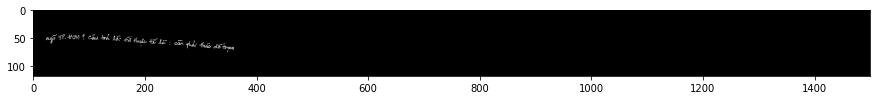

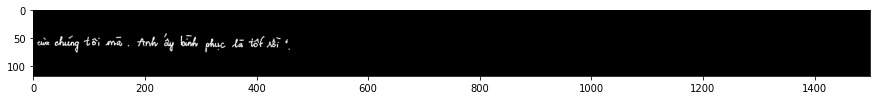

In [40]:
for i in range(2):
    plt.figure(figsize=(15,2))
    plt.imshow(train_images[i][:,:,0], cmap="gray")
    plt.show()

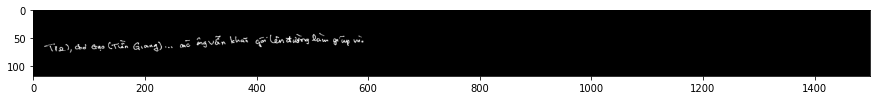

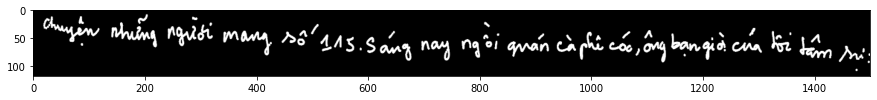

In [41]:
for i in range(2):
    plt.figure(figsize=(15,2))
    plt.imshow(valid_images[i][:,:,0], cmap="gray")
    plt.show()

In [42]:
len(train_images)

5836

In [43]:
train_images = np.array(train_images)
valid_images = np.array(valid_images)

train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [49]:
train_images[0].dtype

dtype('float64')

In [44]:
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/train_images.pk', 'wb') as handle:
    pickle.dump(train_images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/train_padded_label.pk', 'wb') as handle:
    pickle.dump(train_padded_label, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/train_input_length.pk', 'wb') as handle:
    pickle.dump(train_input_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/train_label_length.pk', 'wb') as handle:
    pickle.dump(train_label_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
#----------------------------------------------------------------------------------
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/valid_images.pk', 'wb') as handle:
    pickle.dump(valid_images, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/valid_padded_label.pk', 'wb') as handle:
    pickle.dump(valid_padded_label, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/valid_input_length.pk', 'wb') as handle:
    pickle.dump(valid_input_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../handwirtting_text2/datasets/dataset_2/data_file_pk_ver2/valid_label_length.pk', 'wb') as handle:
    pickle.dump(valid_label_length, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
train_images.shape

(5836, 118, 1500, 1)

## Model

## ----------------------------------------------------------------------------------------------------------------------------

In [22]:
# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization,MaxPooling2D, GRU,Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os,cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.merge import add, concatenate

In [30]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,1150,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(chars)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
model = Model(inputs, outputs)

In [31]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1150, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 1150, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 575, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 575, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 287, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 287, 256)       2951

In [32]:
labels = Input(name='the_labels', shape=[233], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [33]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [34]:
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [35]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 1150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 1150, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 16, 575, 64)  0          ['conv2d_7[0][0]']               
                                                                                            

In [61]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=tf.keras.optimizers.Adam())
# our callbacks hell to optimize our learning
callbacks = [
    
    ModelCheckpoint(
        filepath=os.path.join('checkpoint_weights.hdf5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
# choose batchsize and epochs

batch_size = 32
epochs = 100

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length], 
          y=np.zeros(len(train_images)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/100
  1/183 [..............................] - ETA: 2:20:22 - loss: 1088.0430